# **Tải và import các thư viện cần thiết**

In [ ]:
pip install mlxtend

In [ ]:
pip install pyECLAT

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori
from pyECLAT import ECLAT
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Import bộ dữ liệu**

In [ ]:
!gdown 1gRr3Ca5-wKbBWszLGyEnI_20fB4T8Abt

Downloading...
From: https://drive.google.com/uc?id=1gRr3Ca5-wKbBWszLGyEnI_20fB4T8Abt
To: /content/Google Retail.csv
100% 4.91M/4.91M [00:00<00:00, 28.9MB/s]


In [ ]:
df = pd.read_csv(r"/content/Google Retail.csv")

In [ ]:
df

,InvoiceNo,InvoiceDate,StockCode,Quantity
0,536598,2017-01-01,21421,1
1,536598,2017-01-01,21422,2
2,536598,2017-01-01,22178,26
3,536599,2017-01-01,20749,2
4,536599,2017-01-01,21056,2
...,...,...,...,...
181242,580137,2017-12-31,21977,1
181243,580137,2017-12-31,20914,6
181244,580137,2017-12-31,21034,3
181245,580137,2017-12-31,21588,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181247 entries, 0 to 181246
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    181247 non-null  int64 
 1   InvoiceDate  181247 non-null  object
 2   StockCode    181247 non-null  int64 
 3   Quantity     181247 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.5+ MB


In [ ]:
df.describe()

,InvoiceNo,StockCode,Quantity
count,181247.000000,181247.000000,181247.000000
mean,557388.037297,21355.529625,4.560920
std,12905.503448,1362.139130,20.333066
min,536598.000000,10002.000000,1.000000
25%,545700.000000,21135.000000,1.000000
50%,557026.000000,21672.000000,1.000000
75%,568703.000000,22055.000000,2.000000
max,580137.000000,22314.000000,900.000000


# **Tiền xử lý dữ liệu**

In [ ]:
df.isna().sum()

InvoiceNo      0
InvoiceDate    0
StockCode      0
Quantity       0
dtype: int64

In [ ]:
# Tìm những dòng bị trùng lặp
trunglap = df[df.duplicated(keep=False)]

# Sắp xếp những dòng này theo 3 cột để ta thấy những dòng trùng lặp đứng kế nhau
trunglap = trunglap.sort_values(by=['InvoiceNo', 'StockCode','Quantity'])
trunglap

,InvoiceNo,InvoiceDate,StockCode,Quantity
156,536637,2017-01-01,20733,1
157,536637,2017-01-01,20733,1
155,536637,2017-01-01,22130,1
168,536637,2017-01-01,22130,1
375,536749,2017-01-01,21415,1
...,...,...,...,...
181218,580136,2017-12-31,20794,1
181207,580136,2017-12-31,21976,1
181219,580136,2017-12-31,21976,1
181228,580137,2017-12-31,21731,1


In [ ]:
# Loại những dòng trùng lặp
df.drop_duplicates(inplace=True)

# **Trực quan hóa dữ liệu**

In [ ]:
# Đổi thuộc tính [InvoiceDate] từ dạng object thành thời gian
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Đếm số hóa đơn group by ngày tạo hóa đơn
time_series = df.groupby(df['InvoiceDate'].dt.date)['InvoiceNo'].nunique()

# Tính số hóa đơn trung bình mỗi ngày
mean_hoadon = time_series.mean()

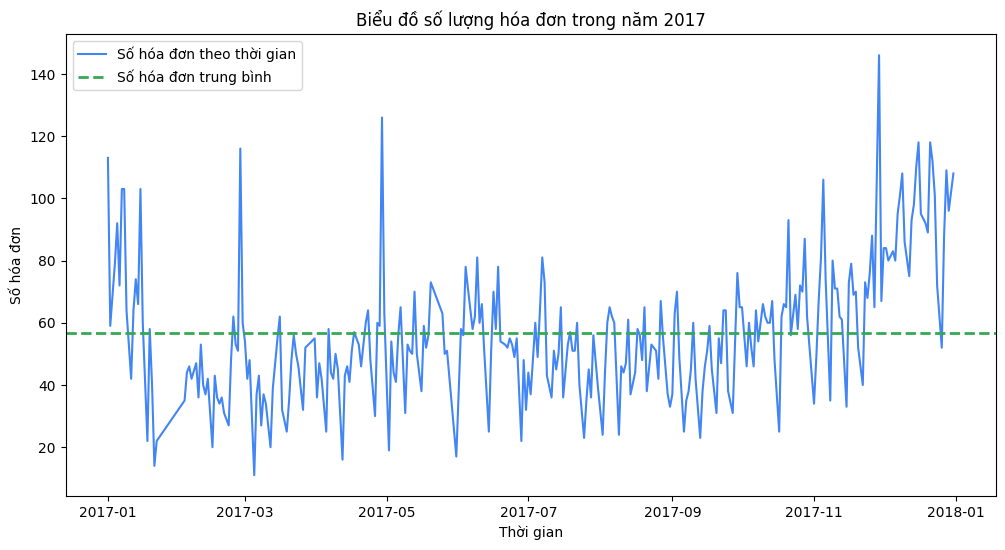

In [ ]:
# Vẽ biểu đồ thời gian
plt.figure(figsize=(12, 6))
sns.lineplot(x=time_series.index, y=time_series.values, color='#4285f4', label='Số hóa đơn theo thời gian')
plt.axhline(mean_hoadon, color='#34a853', linestyle='dashed', linewidth=2, label='Số hóa đơn trung bình')

plt.title('Biểu đồ số lượng hóa đơn trong năm 2017')
plt.xlabel('Thời gian')
plt.ylabel('Số hóa đơn')
plt.legend()
plt.show()

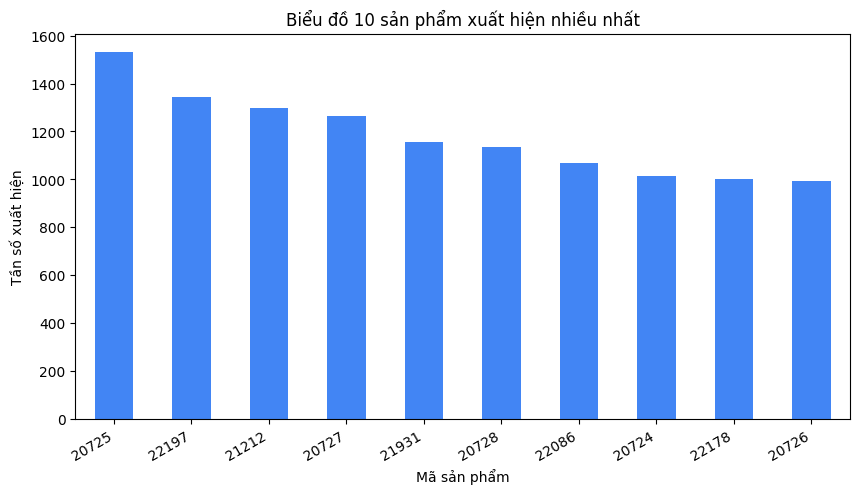

In [ ]:
# Group by stockcode để đếm tần số xuất hiện của từng sản phẩm
tanso_sanpham = df['StockCode'].value_counts()

plt.figure(figsize=(10, 5))
bar = tanso_sanpham.head(10).plot(kind='bar', color='#4285f4')
plt.title('Biểu đồ 10 sản phẩm xuất hiện nhiều nhất')
plt.xlabel('Mã sản phẩm')
plt.ylabel('Tần số xuất hiện')
bar.set_xticklabels(bar.get_xticklabels(), rotation=30, ha='right')

plt.show()

# **Áp dụng thuật toán ECLAT**

In [ ]:
# Group by hóa đơn để biết mỗi hóa đơn mua những sản phẩm nào
hoadon_sanpham = df.groupby('InvoiceNo').agg({'StockCode': list}).reset_index()

# Lưu một dataframe khác để áp dụng thuật toán apriori sau
hoadon_sanpham_apriori = hoadon_sanpham.copy()
hoadon_sanpham

,InvoiceNo,StockCode
0,536598,"[21421, 21422, 22178]"
1,536599,"[20749, 21056]"
2,536600,[21730]
3,536602,"[21871, 21071, 21068, 21730]"
4,536604,[22189]
...,...,...
16517,580133,"[16169, 21843, 20914, 22086, 22083, 22144, 206..."
16518,580134,"[21194, 21208, 20668, 22197]"
16519,580135,"[22086, 21485, 21484, 22142]"
16520,580136,"[16169, 22154, 21216, 21935, 20971, 22274, 207..."


In [ ]:
# Chuyển dạng list trong StockCode thành những chuỗi string
hoadon_sanpham['StockCode'] = hoadon_sanpham['StockCode'].apply(lambda x: ', '.join(map(str, x)))

# Xử lí các khoảng trắng
hoadon_sanpham['StockCode'] = hoadon_sanpham['StockCode'].str.rstrip(', ')

# Tách chuỗi string sang danh sách
df_transformed = hoadon_sanpham['StockCode'].str.split(', ', expand=True)

df_transformed

,0,1,2,3,4,5,6,7,8,9,...,346,347,348,349,350,351,352,353,354,355
0,21421,21422,22178,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,20749,21056,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,21730,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,21871,21071,21068,21730,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,22189,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16517,16169,21843,20914,22086,22083,22144,20676,21790,21326,21873,...,None,None,None,None,None,None,None,None,None,None
16518,21194,21208,20668,22197,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
16519,22086,21485,21484,22142,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
16520,16169,22154,21216,21935,20971,22274,20735,21340,21976,22273,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# Áp dụng eclat, sử dụng hàm time() để tính thời gian chạy thuật toán
start = time.time()
eclat = ECLAT(data=df_transformed, verbose=True)

# Đặt minSup = 0.03, tối đa tập 2 sản phẩm
eclat_index, eclat_support = eclat.fit(min_support=0.03, min_combination=1,
                                       max_combination=2, separator=' & ', verbose=True)
end = time.time()

100%|██████████| 1179/1179 [00:00<00:00, 2401.67it/s]


Combination 1 by 1


65it [00:05, 12.01it/s]


Combination 2 by 2


2080it [01:23, 24.89it/s]


In [ ]:
time_eclat = end - start
print('Thời gian chạy thuật toán ECLAT: ',time_eclat,'giây')

Thời gian chạy thuật toán ECLAT:  352.0870568752289 giây


In [ ]:
itemsets_eclat = pd.DataFrame(eclat_support.items(), columns=['itemsets', 'support'])
itemsets_eclat = itemsets_eclat.sort_values(by='support', ascending=False)
itemsets_eclat

,itemsets,support
12,20725,0.091938
64,22197,0.080317
21,21212,0.077412
11,20727,0.074507
2,21931,0.069544
...,...,...
45,21935,0.030807
18,22144,0.030747
17,22189,0.030686
67,20727 & 20728,0.030626


In [ ]:
itemsets_eclat[itemsets_eclat['itemsets'].str.contains("&")]

,itemsets,support
66,20727 & 20725,0.037405
68,20725 & 20728,0.032684
65,20726 & 20725,0.031171
67,20727 & 20728,0.030626


# **Áp dụng thuật toán APRIORI để so sánh**

In [ ]:
# Sử dụng Transaction Encoder để chuyển đổi những sản phẩm trong hóa đơn thành nhị phân (0 nếu trong hóa đơn không mua sản phẩm đó, 1 nếu có mua)
te = TransactionEncoder()
df_te = te.fit(hoadon_sanpham_apriori['StockCode']).transform(hoadon_sanpham_apriori['StockCode'])

# Đổi từ dạng list thành 1 dataframe hoàn chỉnh
df_te = pd.DataFrame(df_te, columns=te.columns_)
df_te

,10002,10080,10120,10123,10124,10125,10133,10135,11001,15030,...,22305,22306,22307,22308,22309,22310,22311,22312,22313,22314
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16517,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16518,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16519,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16520,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
start = time.time()
# Cũng lấy minSup = 0.03
itemsets_apriori = apriori(df_te, min_support=0.03, use_colnames=True)
itemsets_apriori = itemsets_apriori.sort_values(by='support', ascending=False)
itemsets_apriori = itemsets_apriori.reset_index(drop=True)
end = time.time()

In [ ]:
time_apriori = end - start
print('Thời gian chạy thuật toán Apriori: ',time_apriori,'giây')

Thời gian chạy thuật toán Apriori:  0.34380197525024414 giây


In [ ]:
itemsets_apriori

,support,itemsets
0,0.091938,(20725)
1,0.080317,(22197)
2,0.077412,(21212)
3,0.074507,(20727)
4,0.069544,(21931)
...,...,...
64,0.030807,(21174)
65,0.030747,(22144)
66,0.030686,(22189)
67,0.030626,"(20728, 20727)"


In [ ]:
# Tách những sản phẩm trong cột [itemsets] thành 2 cột riêng
itemsets_apriori[['Sản phẩm 1', 'Sản phẩm 2']] = pd.DataFrame(itemsets_apriori['itemsets'].tolist(), index=itemsets_apriori.index)

# Sau khi tách thì có thể loại cột [itemsets], đổi tên cột support
itemsets_apriori = itemsets_apriori.drop(columns=['itemsets']).rename(columns={'support': 'Support'})

In [ ]:
itemsets_apriori = itemsets_apriori[['Sản phẩm 1', 'Sản phẩm 2', 'Support']]
itemsets_apriori

,Sản phẩm 1,Sản phẩm 2,Support
0,20725,NaN,0.091938
1,22197,NaN,0.080317
2,21212,NaN,0.077412
3,20727,NaN,0.074507
4,21931,NaN,0.069544
...,...,...,...
64,21174,NaN,0.030807
65,22144,NaN,0.030747
66,22189,NaN,0.030686
67,20728,20727.0,0.030626


In [ ]:
itemsets_apriori[itemsets_apriori['Sản phẩm 2'].notna()]

,Sản phẩm 1,Sản phẩm 2,Support
39,20725,20727.0,0.037405
52,20728,20725.0,0.032684
60,20725,20726.0,0.031171
67,20728,20727.0,0.030626
